In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


In [16]:
# Load train/val/test
train_df = pd.read_csv("train_data.csv")
val_df   = pd.read_csv("val_data.csv")
test_df  = pd.read_csv("test_data.csv")

# Separate features and labels
X_train = train_df.iloc[:, :-6]  # all columns except last 6
y_train = train_df.iloc[:, -6:]  # last 6 columns

X_val   = val_df.iloc[:, :-6]
y_val   = val_df.iloc[:, -6:]

X_test  = test_df.iloc[:, :-6]
y_test  = test_df.iloc[:, -6:]

print("Train shape:", X_train.shape, y_train.shape)
print("Validation shape:", X_val.shape, y_val.shape)
print("Test shape:", X_test.shape, y_test.shape)


Train shape: (144, 30) (144, 6)
Validation shape: (31, 30) (31, 6)
Test shape: (32, 30) (32, 6)


In [18]:
n_features = X_train.shape[1]
n_labels = y_train.shape[1]

model = Sequential([
    Dense(128, input_dim=n_features, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(n_labels, activation='sigmoid')  # sigmoid for multi-label
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',         # binary crossentropy for multi-label
    metrics=['accuracy']
)

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               3968      
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 6)                 390       
                                                                 
Total params: 12,614
Trainable params: 12,614
Non-trainable params: 0
_________________________________________________________________


In [19]:
# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop]
)


Epoch 1/50
5/5 [==============================] - 1s 32ms/step - loss: 0.7659 - accuracy: 0.0903 - val_loss: 0.7161 - val_accuracy: 0.0645
Epoch 2/50
5/5 [==============================] - 0s 7ms/step - loss: 0.6953 - accuracy: 0.0903 - val_loss: 0.6795 - val_accuracy: 0.1290
Epoch 3/50
5/5 [==============================] - 0s 7ms/step - loss: 0.6385 - accuracy: 0.2222 - val_loss: 0.6564 - val_accuracy: 0.2258
Epoch 4/50
5/5 [==============================] - 0s 7ms/step - loss: 0.6130 - accuracy: 0.3333 - val_loss: 0.6387 - val_accuracy: 0.2903
Epoch 5/50
5/5 [==============================] - 0s 7ms/step - loss: 0.5862 - accuracy: 0.4167 - val_loss: 0.6243 - val_accuracy: 0.3871
Epoch 6/50
5/5 [==============================] - 0s 6ms/step - loss: 0.5574 - accuracy: 0.4306 - val_loss: 0.6109 - val_accuracy: 0.4516
Epoch 7/50
5/5 [==============================] - 0s 7ms/step - loss: 0.5374 - accuracy: 0.3889 - val_loss: 0.5998 - val_accuracy: 0.5161
Epoch 8/50
5/5 [=================

In [20]:
import numpy as np

# Predict probabilities
y_pred_prob = model.predict(X_test)

# Convert probabilities to binary labels (threshold 0.5)
y_pred = (y_pred_prob >= 0.5).astype(int)


1/1 [==============================] - 0s 38ms/step


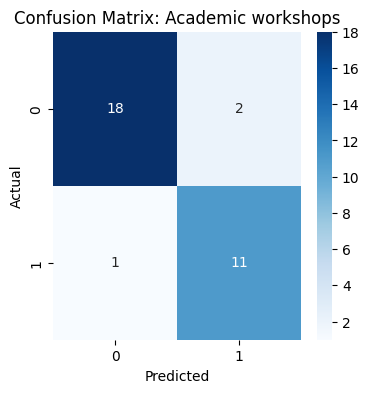

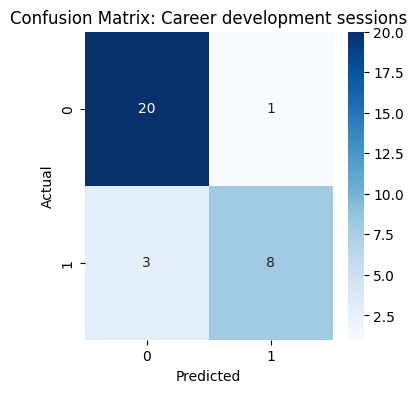

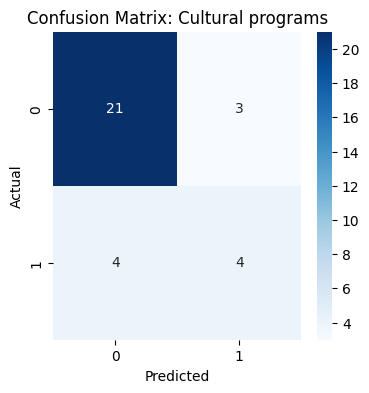

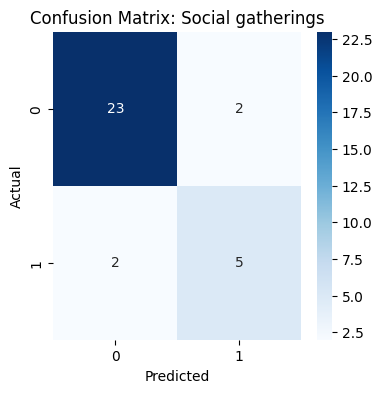

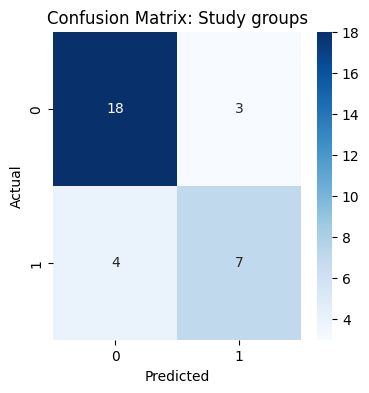

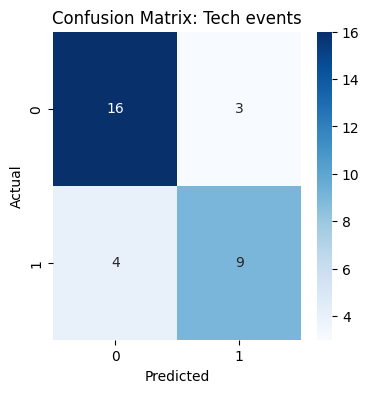

In [22]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Make sure y_test is a NumPy array
y_test_np = y_test.values if isinstance(y_test, pd.DataFrame) else y_test

# y_pred should already be a NumPy array
y_pred_np = y_pred

label_cols = [
    'Academic workshops',
    'Career development sessions',
    'Cultural programs',
    'Social gatherings',
    'Study groups',
    'Tech events'
]

# Plot per-label confusion matrices
for i, label in enumerate(label_cols):
    cm = confusion_matrix(y_test_np[:, i], y_pred_np[:, i])
    
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix: {label}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


In [23]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, hamming_loss
import numpy as np
import pandas as pd


In [24]:
metrics = []

for i, label in enumerate(label_cols):
    acc = accuracy_score(y_test_np[:, i], y_pred_np[:, i])
    prec = precision_score(y_test_np[:, i], y_pred_np[:, i], zero_division=0)
    rec = recall_score(y_test_np[:, i], y_pred_np[:, i], zero_division=0)
    f1 = f1_score(y_test_np[:, i], y_pred_np[:, i], zero_division=0)
    
    metrics.append([label, acc, prec, rec, f1])

metrics_df = pd.DataFrame(metrics, columns=['Label', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])
print(metrics_df)


                         Label  Accuracy  Precision    Recall  F1-Score
0           Academic workshops   0.90625   0.846154  0.916667  0.880000
1  Career development sessions   0.87500   0.888889  0.727273  0.800000
2            Cultural programs   0.78125   0.571429  0.500000  0.533333
3            Social gatherings   0.87500   0.714286  0.714286  0.714286
4                 Study groups   0.78125   0.700000  0.636364  0.666667
5                  Tech events   0.78125   0.750000  0.692308  0.720000


In [25]:
# Micro-averaged metrics (treat all labels together)
micro_precision = precision_score(y_test_np, y_pred_np, average='micro', zero_division=0)
micro_recall    = recall_score(y_test_np, y_pred_np, average='micro', zero_division=0)
micro_f1        = f1_score(y_test_np, y_pred_np, average='micro', zero_division=0)

# Hamming loss
hl = hamming_loss(y_test_np, y_pred_np)

print(f"Micro Precision: {micro_precision:.3f}")
print(f"Micro Recall:    {micro_recall:.3f}")
print(f"Micro F1-Score:  {micro_f1:.3f}")
print(f"Hamming Loss:    {hl:.3f}")


Micro Precision: 0.759
Micro Recall:    0.710
Micro F1-Score:  0.733
Hamming Loss:    0.167


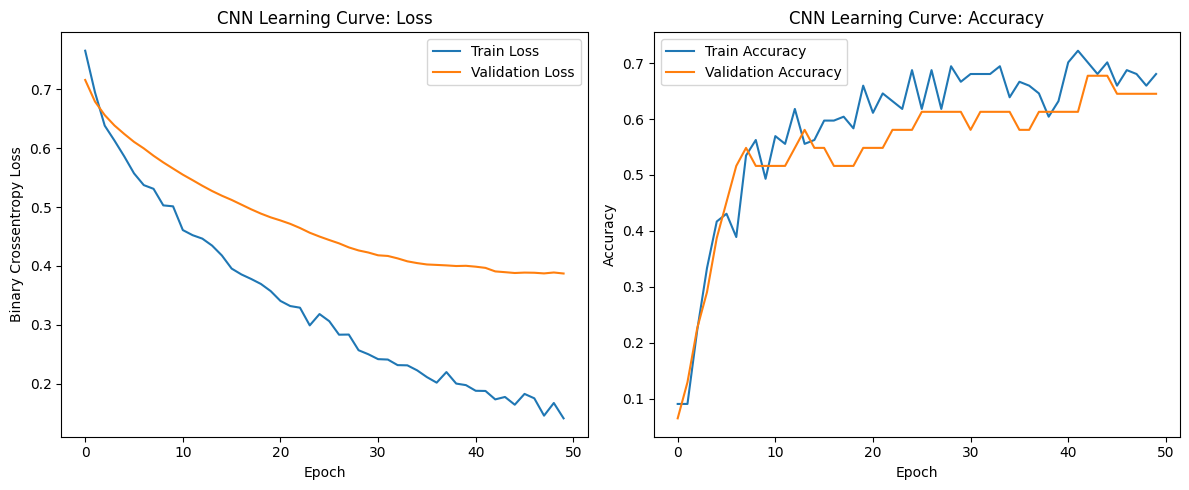

In [27]:
import matplotlib.pyplot as plt

# Loss curve
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Binary Crossentropy Loss')
plt.title('CNN Learning Curve: Loss')
plt.legend()


# Accuracy curve
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('CNN Learning Curve: Accuracy')
plt.legend()


plt.tight_layout()
plt.show()


In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop

def build_dense_model(n_features, n_labels, neurons1=128, neurons2=64,
                      dropout1=0.3, dropout2=0.2, optimizer_name='adam', lr=0.001):
    model = Sequential()
    model.add(Dense(neurons1, input_dim=n_features, activation='relu'))
    model.add(Dropout(dropout1))
    model.add(Dense(neurons2, activation='relu'))
    model.add(Dropout(dropout2))
    model.add(Dense(n_labels, activation='sigmoid'))
    
    if optimizer_name == 'adam':
        optimizer = Adam(learning_rate=lr)
    elif optimizer_name == 'nadam':
        optimizer = Nadam(learning_rate=lr)
    elif optimizer_name == 'rmsprop':
        optimizer = RMSprop(learning_rate=lr)
    
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [29]:
import itertools

param_grid = {
    'neurons1': [64, 128],
    'neurons2': [32, 64],
    'dropout1': [0.2, 0.3],
    'dropout2': [0.2, 0.3],
    'optimizer_name': ['adam', 'nadam'],
    'lr': [0.001, 0.0005]
}

# Generate all combinations
keys, values = zip(*param_grid.items())
combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]
print(f"Total combinations: {len(combinations)}")


Total combinations: 64


In [30]:
from sklearn.metrics import f1_score

best_f1 = 0
best_params = None

n_features = X_train.shape[1]
n_labels = y_train.shape[1]

for i, params in enumerate(combinations):
    print(f"\nTraining combination {i+1}/{len(combinations)}: {params}")
    
    model = build_dense_model(
        n_features=n_features,
        n_labels=n_labels,
        neurons1=params['neurons1'],
        neurons2=params['neurons2'],
        dropout1=params['dropout1'],
        dropout2=params['dropout2'],
        optimizer_name=params['optimizer_name'],
        lr=params['lr']
    )
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=20,
        batch_size=32,
        verbose=0
    )
    
    y_pred_prob = model.predict(X_val)
    y_pred = (y_pred_prob >= 0.5).astype(int)
    f1 = f1_score(y_val, y_pred, average='micro')
    
    print(f"Micro F1-score: {f1:.4f}")
    
    if f1 > best_f1:
        best_f1 = f1
        best_params = params

print("\nBest hyperparameters found:")
print(best_params)
print(f"Best Micro F1-score: {best_f1:.4f}")



Training combination 1/64: {'neurons1': 64, 'neurons2': 32, 'dropout1': 0.2, 'dropout2': 0.2, 'optimizer_name': 'adam', 'lr': 0.001}
1/1 [==============================] - 0s 63ms/step
Micro F1-score: 0.6218

Training combination 2/64: {'neurons1': 64, 'neurons2': 32, 'dropout1': 0.2, 'dropout2': 0.2, 'optimizer_name': 'adam', 'lr': 0.0005}
1/1 [==============================] - 0s 41ms/step
Micro F1-score: 0.3711

Training combination 3/64: {'neurons1': 64, 'neurons2': 32, 'dropout1': 0.2, 'dropout2': 0.2, 'optimizer_name': 'nadam', 'lr': 0.001}
1/1 [==============================] - 0s 62ms/step
Micro F1-score: 0.5862

Training combination 4/64: {'neurons1': 64, 'neurons2': 32, 'dropout1': 0.2, 'dropout2': 0.2, 'optimizer_name': 'nadam', 'lr': 0.0005}
1/1 [==============================] - 0s 42ms/step
Micro F1-score: 0.4425

Training combination 5/64: {'neurons1': 64, 'neurons2': 32, 'dropout1': 0.2, 'dropout2': 0.3, 'optimizer_name': 'adam', 'lr': 0.001}
1/1 [=====================

1/1 [==============================] - 0s 38ms/step
Micro F1-score: 0.6667

Training combination 34/64: {'neurons1': 128, 'neurons2': 32, 'dropout1': 0.2, 'dropout2': 0.2, 'optimizer_name': 'adam', 'lr': 0.0005}
1/1 [==============================] - 0s 38ms/step
Micro F1-score: 0.7000

Training combination 35/64: {'neurons1': 128, 'neurons2': 32, 'dropout1': 0.2, 'dropout2': 0.2, 'optimizer_name': 'nadam', 'lr': 0.001}
1/1 [==============================] - 0s 39ms/step
Micro F1-score: 0.6774

Training combination 36/64: {'neurons1': 128, 'neurons2': 32, 'dropout1': 0.2, 'dropout2': 0.2, 'optimizer_name': 'nadam', 'lr': 0.0005}
1/1 [==============================] - 0s 39ms/step
Micro F1-score: 0.5455

Training combination 37/64: {'neurons1': 128, 'neurons2': 32, 'dropout1': 0.2, 'dropout2': 0.3, 'optimizer_name': 'adam', 'lr': 0.001}
1/1 [==============================] - 0s 41ms/step
Micro F1-score: 0.6299

Training combination 38/64: {'neurons1': 128, 'neurons2': 32, 'dropout1': 0.

In [32]:
import numpy as np

# Combine features
X_combined = np.vstack([X_train, X_val])

# Combine labels
y_combined = np.vstack([y_train.values, y_val.values])

print("Combined features shape:", X_combined.shape)
print("Combined labels shape:", y_combined.shape)


Combined features shape: (175, 30)
Combined labels shape: (175, 6)


In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

n_features = X_combined.shape[1]
n_labels = y_combined.shape[1]

# Best hyperparameters
best_params = {
    'neurons1': 128,
    'neurons2': 64,
    'dropout1': 0.2,
    'dropout2': 0.2,
    'optimizer_name': 'adam',
    'lr': 0.001
}

# Build model
model_final = Sequential([
    Dense(best_params['neurons1'], input_dim=n_features, activation='relu'),
    Dropout(best_params['dropout1']),
    Dense(best_params['neurons2'], activation='relu'),
    Dropout(best_params['dropout2']),
    Dense(n_labels, activation='sigmoid')
])

optimizer = Adam(learning_rate=best_params['lr'])
model_final.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model_final.summary()


Model: "sequential_66"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_198 (Dense)           (None, 128)               3968      
                                                                 
 dropout_132 (Dropout)       (None, 128)               0         
                                                                 
 dense_199 (Dense)           (None, 64)                8256      
                                                                 
 dropout_133 (Dropout)       (None, 64)                0         
                                                                 
 dense_200 (Dense)           (None, 6)                 390       
                                                                 
Total params: 12,614
Trainable params: 12,614
Non-trainable params: 0
_________________________________________________________________


In [34]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_final = model_final.fit(
    X_combined, y_combined,
    validation_split=0.1,  # Use 10% of combined data as validation
    epochs=50,
    batch_size=32,
    callbacks=[early_stop]
)


Epoch 1/50
5/5 [==============================] - 1s 34ms/step - loss: 0.6949 - accuracy: 0.0892 - val_loss: 0.7142 - val_accuracy: 0.0556
Epoch 2/50
5/5 [==============================] - 0s 8ms/step - loss: 0.6403 - accuracy: 0.1720 - val_loss: 0.6632 - val_accuracy: 0.1111
Epoch 3/50
5/5 [==============================] - 0s 7ms/step - loss: 0.6080 - accuracy: 0.2994 - val_loss: 0.6239 - val_accuracy: 0.2778
Epoch 4/50
5/5 [==============================] - 0s 8ms/step - loss: 0.5728 - accuracy: 0.3567 - val_loss: 0.5916 - val_accuracy: 0.3889
Epoch 5/50
5/5 [==============================] - 0s 8ms/step - loss: 0.5578 - accuracy: 0.4140 - val_loss: 0.5637 - val_accuracy: 0.5000
Epoch 6/50
5/5 [==============================] - 0s 9ms/step - loss: 0.5307 - accuracy: 0.5032 - val_loss: 0.5378 - val_accuracy: 0.6667
Epoch 7/50
5/5 [==============================] - 0s 10ms/step - loss: 0.5132 - accuracy: 0.5159 - val_loss: 0.5155 - val_accuracy: 0.6667
Epoch 8/50
5/5 [================

In [35]:
# Predict probabilities
y_pred_prob = model_final.predict(X_test)
y_pred = (y_pred_prob >= 0.5).astype(int)


1/1 [==============================] - 0s 39ms/step


In [36]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, hamming_loss
import pandas as pd

label_cols = [
    'Academic workshops',
    'Career development sessions',
    'Cultural programs',
    'Social gatherings',
    'Study groups',
    'Tech events'
]

# Per-label metrics
metrics = []
for i, label in enumerate(label_cols):
    acc = accuracy_score(y_test.values[:, i], y_pred[:, i])
    prec = precision_score(y_test.values[:, i], y_pred[:, i], zero_division=0)
    rec = recall_score(y_test.values[:, i], y_pred[:, i], zero_division=0)
    f1 = f1_score(y_test.values[:, i], y_pred[:, i], zero_division=0)
    metrics.append([label, acc, prec, rec, f1])

metrics_df = pd.DataFrame(metrics, columns=['Label', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])
print(metrics_df)

# Overall multi-label metrics
micro_precision = precision_score(y_test, y_pred, average='micro', zero_division=0)
micro_recall    = recall_score(y_test, y_pred, average='micro', zero_division=0)
micro_f1        = f1_score(y_test, y_pred, average='micro', zero_division=0)
hl = hamming_loss(y_test, y_pred)

print(f"\nMicro Precision: {micro_precision:.3f}")
print(f"Micro Recall:    {micro_recall:.3f}")
print(f"Micro F1-Score:  {micro_f1:.3f}")
print(f"Hamming Loss:    {hl:.3f}")


                         Label  Accuracy  Precision    Recall  F1-Score
0           Academic workshops   0.87500   0.750000  1.000000  0.857143
1  Career development sessions   0.87500   0.769231  0.909091  0.833333
2            Cultural programs   0.78125   0.571429  0.500000  0.533333
3            Social gatherings   0.87500   0.800000  0.571429  0.666667
4                 Study groups   0.75000   0.666667  0.545455  0.600000
5                  Tech events   0.78125   0.714286  0.769231  0.740741

Micro Precision: 0.719
Micro Recall:    0.742
Micro F1-Score:  0.730
Hamming Loss:    0.177


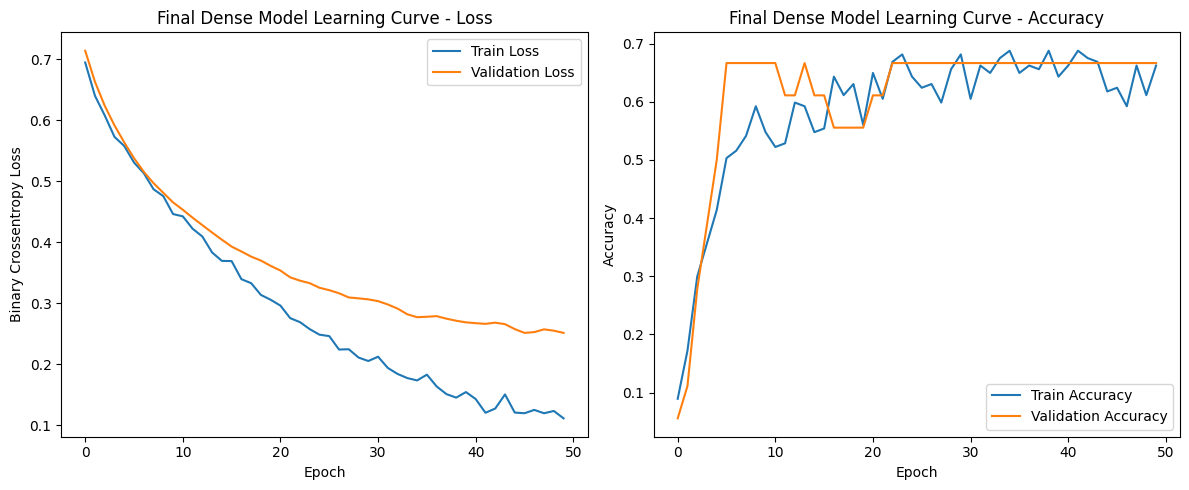

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Loss
plt.subplot(1,2,1)
plt.plot(history_final.history['loss'], label='Train Loss')
plt.plot(history_final.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Binary Crossentropy Loss')
plt.title('Final Dense Model Learning Curve - Loss')
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(history_final.history['accuracy'], label='Train Accuracy')
plt.plot(history_final.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Final Dense Model Learning Curve - Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
